<a href="https://colab.research.google.com/github/sbogde/pandamonium/blob/main/My_WS03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !pip install wordcloud

In [10]:
import csv
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import warnings

In [11]:
time.sleep(2)
warnings.filterwarnings('ignore')

In [17]:
## Define URLs for Scraping IMDB Reviews
urls = [
    'https://www.imdb.com/title/tt0111161/reviews/?ref_=tt_ql_urv',
    'https://www.imdb.com/title/tt1213644/reviews/?ref_=tt_ql_urv',
    'https://www.imdb.com/title/tt6856242/reviews/?ref_=tt_ql_urv',
    'https://www.imdb.com/title/tt8356942/reviews/?ref_=tt_ql_urv',
    'https://www.imdb.com/title/tt0060666/reviews/?ref_=tt_ql_urv'
]

# content = []
# for url in urls:
#     page = requests.get(url, timeout=2.50)
#     soup = BeautifulSoup(page.content, 'html.parser')
#     content.append(soup.find_all('div', class_='review-container'))

# Initialize lists to store extracted reviews and ratings
reviews_list = []
ratings_list = []

# Iterate over each movie URL
for url in urls:
    print(f"Scraping: {url}")
    headers = {'User-Agent': 'Mozilla/5.0'}  # Prevent getting blocked
    page = requests.get(url, headers=headers)

    # Parse the page content
    soup = BeautifulSoup(page.content, 'html.parser')

    # Find all review containers
    # review_containers = soup.find_all('article', class_='sc-7d2e5b85-1 cvfQlw user-review-item')
    review_containers = soup.find_all('article', class_='sc-8c92b587-1 cwztqu user-review-item')

    # Extract review text and rating
    for container in review_containers:
        # Extract review text
        review_element = container.find('div', class_='ipc-html-content-inner-div')
        review_text = review_element.get_text(strip=True) if review_element else "No Review"

        # Extract rating
        rating_element = container.find('span', class_='ipc-rating-star--rating')
        rating = rating_element.get_text(strip=True) if rating_element else "NA"

        # Append to lists
        reviews_list.append(review_text)
        ratings_list.append(rating)

        # print(f"Review: {review_text[:100]}...")  # Print preview
        # print(f"Rating: {rating}\n")

    # Sleep to prevent being blocked
    time.sleep(2)

# Create DataFrame
movie = pd.DataFrame({'Review': reviews_list, 'Rating': ratings_list})

Scraping: https://www.imdb.com/title/tt0111161/reviews/?ref_=tt_ql_urv
Scraping: https://www.imdb.com/title/tt1213644/reviews/?ref_=tt_ql_urv
Scraping: https://www.imdb.com/title/tt6856242/reviews/?ref_=tt_ql_urv
Scraping: https://www.imdb.com/title/tt8356942/reviews/?ref_=tt_ql_urv
Scraping: https://www.imdb.com/title/tt0060666/reviews/?ref_=tt_ql_urv


In [18]:
movie.head()

,Review,Rating
0,No Review,10
1,It is no wonder that the film has such a high ...,10
2,I'm trying to save you money; this is the last...,10
3,No Review,10
4,This movie is not your ordinary Hollywood flic...,10


In [19]:
# Display first few rows
print(movie.head())
print(movie.info())

                                              Review Rating
0                                          No Review     10
1  It is no wonder that the film has such a high ...     10
2  I'm trying to save you money; this is the last...     10
3                                          No Review     10
4  This movie is not your ordinary Hollywood flic...     10
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  125 non-null    object
 1   Rating  125 non-null    object
dtypes: object(2)
memory usage: 2.1+ KB
None


In [21]:
# Save to CSV
movie.to_csv('Workshop3_IMDB_Dataset.csv', index=False)

In [22]:
# Convert Rating to string first, then replace non-numeric values safely
movie['Rating'] = pd.to_numeric(movie['Rating'], errors='coerce')

# Fill NaN values with a default value (e.g., 0) before converting to integer
movie['Rating'] = movie['Rating'].fillna(0).astype(int)

In [23]:
### Extract Reviews and Ratings
## Text Processing and Analysis
### Importing Required Libraries
import string
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

In [24]:
### WordCloud Visualization

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

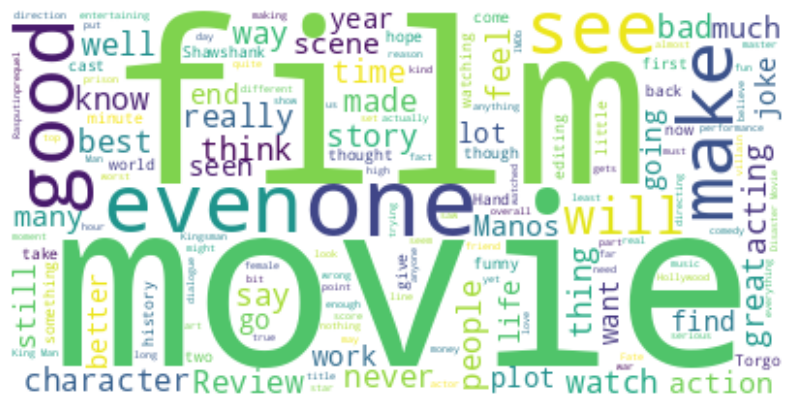

In [25]:
text = ', '.join(t for t in movie['Review'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [26]:
##Sentiment Identification using VADER

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
sentiments = []

for review in movie['Review']:
    score = sid.polarity_scores(review)['compound']
    if score >= 0.05:
        sentiments.append('positive')
    elif score <= -0.05:
        sentiments.append('negative')
    else:
        sentiments.append('neutral')

movie['Sentiment'] = sentiments

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [27]:
## Sentiment Classification using Machine Learning

movie['class-label'] = movie['Rating'].astype(int).apply(lambda x: '1' if x > 5 else ('-1' if x < 5 else '0'))
movie = movie[movie['class-label'] != '0']

tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
X = tfidf_vectorizer.fit_transform(movie['Review'])
y = movie['class-label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=8)

In [31]:
## Train and Evaluate SVM Classifier

from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

svc = SVC(kernel='sigmoid', gamma=1.0)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.6486486486486487


In [32]:
print('Confusion Matrix:')
confusion_matrix(y_test, y_pred)

Confusion Matrix:


array([[14,  4],
       [ 9, 10]])

In [33]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.61      0.78      0.68        18
           1       0.71      0.53      0.61        19

    accuracy                           0.65        37
   macro avg       0.66      0.65      0.64        37
weighted avg       0.66      0.65      0.64        37



In [35]:
## Train and Evaluate Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.5135135135135135


In [36]:
print('Confusion Matrix:')
confusion_matrix(y_test, y_pred)

Confusion Matrix:


array([[14,  4],
       [14,  5]])

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.78      0.61        18
           1       0.56      0.26      0.36        19

    accuracy                           0.51        37
   macro avg       0.53      0.52      0.48        37
weighted avg       0.53      0.51      0.48        37

